In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf
"""from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint"""

'from tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\nfrom tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D\nfrom tensorflow.keras import utils\nfrom tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint'

In [2]:
zip_path = "/content/drive/MyDrive/Datasets/archive (2).zip"

with ZipFile(zip_path, 'r') as myzip:
    myzip.extractall()
    print('Unzipping completed!')

Unzipping completed!


In [3]:
filename='/content/crop_part1/10_0_0_20161220222308131.jpg.chip.jpg'

# Extract filename extension
base, extension = os.path.splitext(filename)
print("Extracted extension:", extension)
print("Full directory: ",base)
# Extract basename (filename without extension)
basename = os.path.basename(filename)
print("Extracted basename:", basename[:-13])
# Extract directory path
directory_path = os.path.dirname(filename)
print("Extracted directory path:", directory_path)

print("\nFeatures: ",basename[:-13].split('_'))

Extracted extension: .jpg
Full directory:  /content/crop_part1/10_0_0_20161220222308131.jpg.chip
Extracted basename: 10_0_0_20161220222308131
Extracted directory path: /content/crop_part1

Features:  ['10', '0', '0', '20161220222308131']


In [4]:
def get_age_range(age):
  if age<=20: return 0
  if age<=40: return 1
  if age<=60: return 2
  if age<=80: return 3
  return 4

def get_age(age):
  age_dict = {0:'0-20',1:'20-40',2:'40-60',3:'60-80',4:'80-inf'}
  return age_dict[age]

In [5]:
files = os.listdir('/content/crop_part1') #insert folder path

structured_files = []
for file in files:
    age, age_range,img_name= file.split('_')[0],get_age_range(int(file.split('_')[0])),file
    structured_files.append({'Age':age, 'Age Range':age_range, 'Image':img_name})

In [6]:
data=pd.DataFrame(structured_files)
data.head()

,Age,Age Range,Image
0,41,2,41_1_0_20170103181204176.jpg.chip.jpg
1,38,1,38_1_0_20170104183625399.jpg.chip.jpg
2,4,0,4_0_1_20170110213631827.jpg.chip.jpg
3,18,0,18_1_0_20170109214113667.jpg.chip.jpg
4,26,1,26_0_4_20170103235645596.jpg.chip.jpg


In [7]:
data.shape

(9780, 3)

In [8]:
value_counts = data['Age Range'].value_counts()
value_counts

0    4267
1    2533
2    1665
3     969
4     346
Name: Age Range, dtype: int64

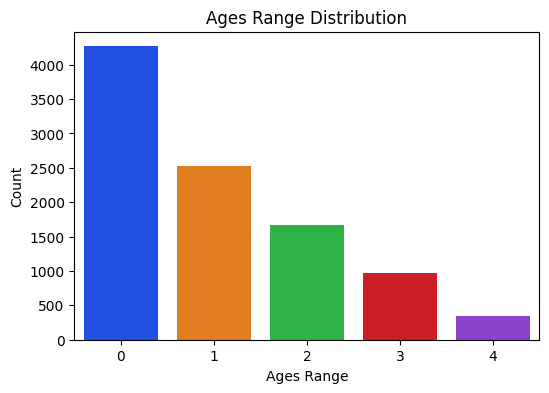

In [9]:
colors = sns.color_palette("bright", len(value_counts))
plt.figure(figsize=(6,4))
ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette=colors)
plt.title('Ages Range Distribution')
plt.xlabel('Ages Range')
plt.ylabel('Count')
plt.show()

In [10]:
train_data = data.sample(frac = 0.8,random_state = 25)
left_data = data.drop(train_data.index)

val_data = left_data.sample(frac = 0.6, random_state = 25)
test_data = left_data.drop(val_data.index)

In [11]:
print("Train Data:",train_data.shape)
print("Test Data:", test_data.shape)
print("Val data:", val_data.shape)

Train Data: (7824, 3)
Test Data: (782, 3)
Val data: (1174, 3)


In [47]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
base_dir = '/content/UTKFace'


train_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=  preprocess_input)
val_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function= preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=  preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe = train_data,
                  directory = base_dir,
                  x_col= 'Image',
                  y_col = 'Age Range',
                  class_mode = 'raw',
                  shuffle = False,
                  target_size=[128,128],
                  batch_size = 128,
                  color_mode='rgb')
val_generator = val_datagen.flow_from_dataframe(
                  dataframe = val_data,
                  directory = base_dir,
                  x_col= 'Image',
                  y_col = 'Age Range',
                  class_mode = 'raw',
                  shuffle = False,
                  target_size=[128,128],
                  batch_size = 128,
                  color_mode='rgb')
test_generator = test_datagen.flow_from_dataframe(
                  dataframe = test_data,
                  directory = base_dir,
                  x_col= 'Image',
                  y_col = 'Age Range',
                  class_mode = 'raw',
                  shuffle = False,
                  target_size=[128,128],
                  batch_size = 128,
                  color_mode='rgb')

Found 7823 validated image filenames.
Found 1174 validated image filenames.
Found 782 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


In [48]:
from keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape = [128,128,3], weights='imagenet', include_top=False)

In [49]:
for layer in vgg.layers:
  layer.trainable = False


layer = keras.layers.Flatten()(vgg.output)
layer = keras.layers.Dense(4096, activation='relu')(layer)
layer = keras.layers.Dense(4096, activation='relu')(layer)
prediction = keras.layers.Dense(5, activation='softmax')(layer)
model = keras.models.Model(inputs=vgg.input, outputs=prediction)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [56]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
earlycallback  = EarlyStopping(monitor ="val_sparse_categorical_accuracy", mode ="auto", patience = 5, restore_best_weights = True)
callback_list = [earlycallback]

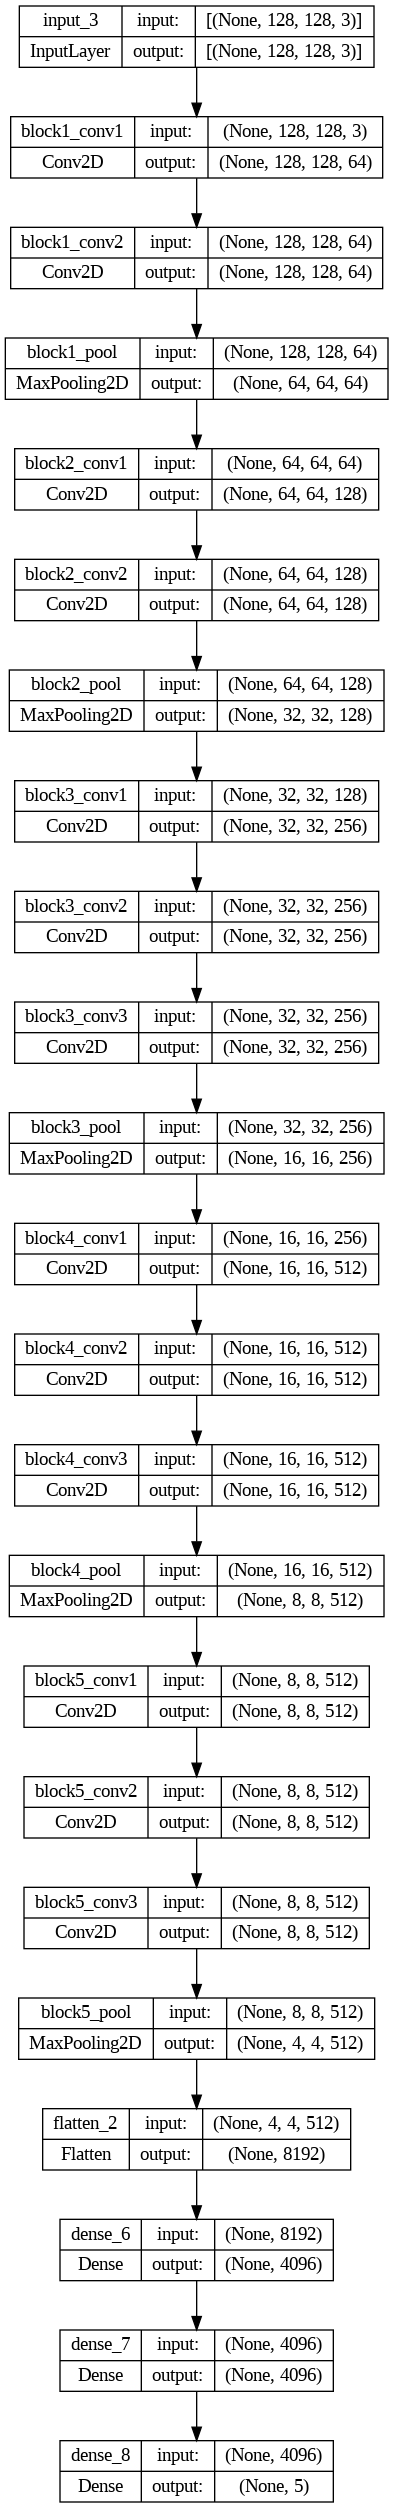

In [57]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

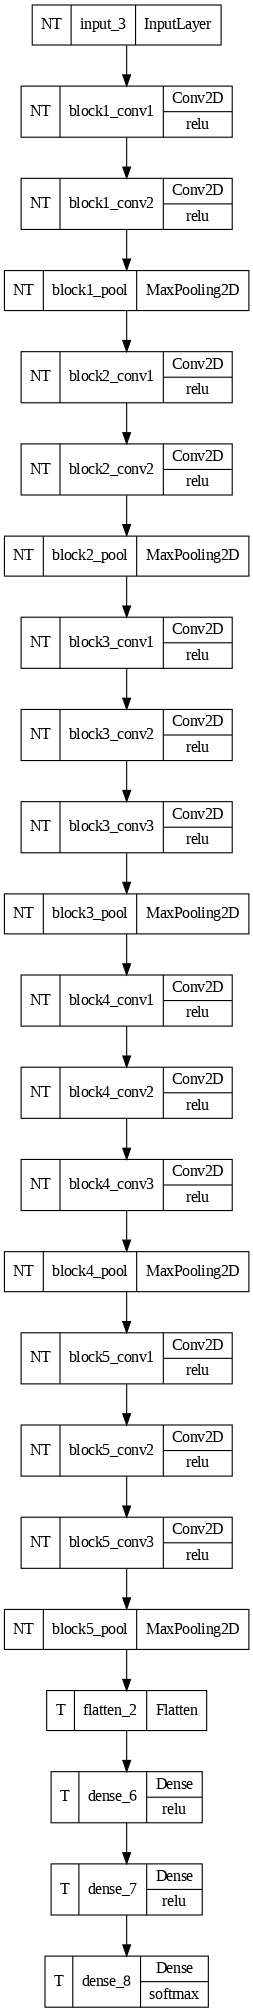

In [58]:
plot_model(
    model,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=80,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [63]:
result = model.fit_generator(train_generator,epochs=25,validation_data=val_generator)#,callbacks= callback_list)

Epoch 1/25


<ipython-input-63-19ff439337e2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = model.fit_generator(train_generator,epochs=25,validation_data=val_generator)#,callbacks= callback_list)


62/62 [==============================] - 15s 235ms/step - loss: 0.2432 - sparse_categorical_accuracy: 0.9043 - val_loss: 1.0377 - val_sparse_categorical_accuracy: 0.7240
Epoch 2/25
62/62 [==============================] - 15s 239ms/step - loss: 0.1872 - sparse_categorical_accuracy: 0.9283 - val_loss: 1.0483 - val_sparse_categorical_accuracy: 0.7249
Epoch 3/25
62/62 [==============================] - 15s 246ms/step - loss: 0.1870 - sparse_categorical_accuracy: 0.9284 - val_loss: 1.0913 - val_sparse_categorical_accuracy: 0.7112
Epoch 4/25
62/62 [==============================] - 15s 238ms/step - loss: 0.1599 - sparse_categorical_accuracy: 0.9380 - val_loss: 1.1457 - val_sparse_categorical_accuracy: 0.7223
Epoch 5/25
62/62 [==============================] - 14s 228ms/step - loss: 0.1169 - sparse_categorical_accuracy: 0.9568 - val_loss: 1.2170 - val_sparse_categorical_accuracy: 0.7061
Epoch 6/25
62/62 [==============================] - 15s 241ms/step - loss: 0.1376 - sparse_categorical_acc

4/4 [==============================] - 0s 60ms/step


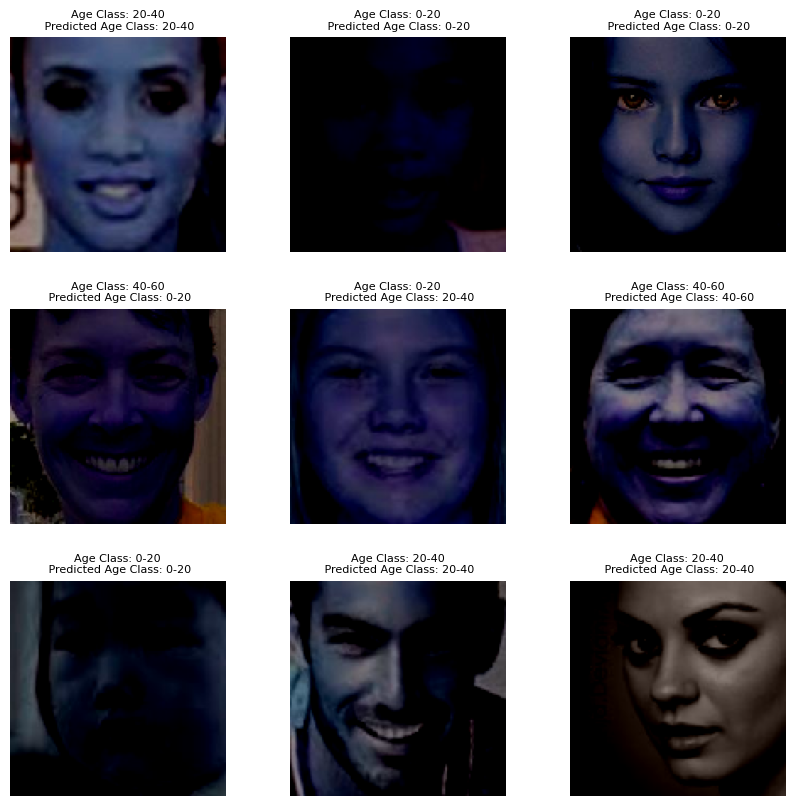

In [64]:
def show_faces(images, age=None, pred_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Age": [pred_age, age]}
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.axis('off')
        plt.imshow(images[i])

        if pred_age[i] is None:
            continue


        real_age = int(age[i])
        predicted_age = np.argmax(predicted[i])


        plt.title(f"Age Class: {get_age(real_age)}\n Predicted Age Class: {get_age(predicted_age)}", fontsize=8)

        plt.subplots_adjust(wspace=0.3)

sample_validation_images, sample_validation_labels = next(test_generator)
predicted = model.predict(sample_validation_images)
show_faces(sample_validation_images, age=sample_validation_labels, pred_age=predicted)

In [65]:
# Access the history attribute of the History object
history_dict = result.history

print("Loss: ", history_dict['loss'][-1])
print("Accuracy: ", history_dict['val_sparse_categorical_accuracy'][-1])


Loss:  0.19786503911018372
Accuracy:  0.6993185877799988
